In [1]:
## Main
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Torch
import torch
from torch import nn
from torch.optim import Adam, RMSprop
from torch.distributions.beta import Beta
from torch.distributions.chi2 import Chi2
from torch.distributions.cauchy import Cauchy
from torch.distributions.normal import Normal
from torch.distributions.studentT import StudentT
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal

## OT
import ot
from ot import wasserstein_1d
from ot import sinkhorn, sinkhorn2

## Other useful
from src.torch import *

In [2]:
cfg = {
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "batch_size":torch.Size([64]),
    "batch_size_dist":torch.Size([64, 3]),
    "val_batch_size":torch.Size([100]),
    "num_epochs":500,
    "w_gp":10,
    "c_Clip":0.01,
    "lr_Clip":5e-4,
    "lr_GP":1e-3,
    "betas_GP":(0, 0.9),
    "lr_c":1e-4,
    "lr_c_eps":1e-4,
    "(c,eps)_eps":1,
    "Sinkhorn_eps":0.01,
    "size":3,
    "train_epoches":500,
    "val_epoches":100,
}

### Distributions Experiments

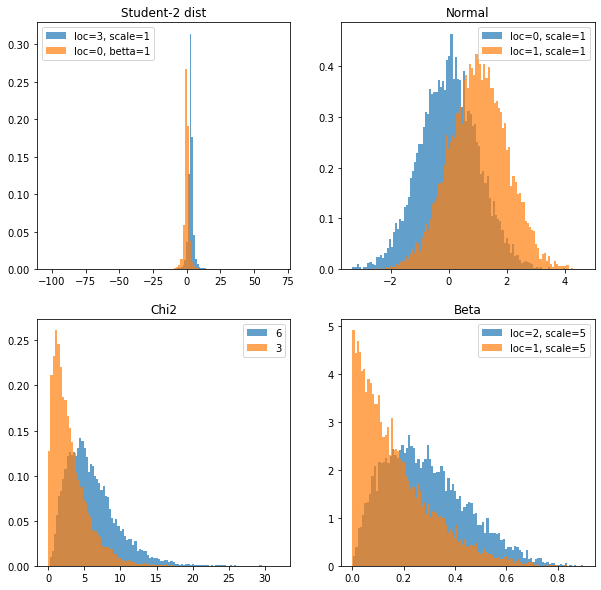

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
dist = StudentT(2, 3, 1)
_ = axs[0, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=3, scale=1")
dist = StudentT(2, 0, 1)
_ = axs[0, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=0, betta=1")
axs[0, 0].legend()
axs[0, 0].set_title("Student-2 dist")

dist = Normal(0, 1)
_ = axs[0, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=0, scale=1")
dist = Normal(1, 1)
_ = axs[0, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=1, scale=1")
axs[0, 1].legend()
axs[0, 1].set_title("Normal")

dist = Chi2(6)
_ = axs[1, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="6")
dist = Chi2(3)
_ = axs[1, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="3")
axs[1, 0].legend()
axs[1, 0].set_title("Chi2")

dist = Beta(2, 5)
_ = axs[1, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=2, scale=5")
dist = Beta(1, 5)
_ = axs[1, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=1, scale=5")
axs[1, 1].legend()
axs[1, 1].set_title("Beta")
plt.show()

In [26]:
dist_names = ["Student-2", "Normal", "Beta", "Chi2"]
model_names = ["WGANGP", "WGANClip", "WGANc", "WGANc_eps", "Sinkhorn"]
dist_map = {
    "Student-2":{
        "1":StudentT(df=2, loc=3, scale=1),
        "2":StudentT(df=2, loc=0, scale=1),
    },
    "Normal":{
        "1":Normal(loc=1, scale=1),
        "2":Normal(loc=0, scale=1)
    },
    "Beta":{
        "1":Beta(concentration1=3, concentration0=5),
        "2":Beta(concentration1=1, concentration0=5)
    },
    "Chi2":{
        "1":Chi2(df=6),
        "2":Chi2(df=3)
    }
}

#### WGAN Clip

In [27]:
clipper = WeightClipper(cfg['c_Clip'])
netD_Clip_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(cfg["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(cfg["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_Clip_map = dict(zip(dist_names, [RMSprop(
                                               netD_Clip_map[name].parameters(),
                                               lr=cfg["lr_Clip"]
                                            ) for name in dist_names
                                        ]
                                    )
                                )

#### WGAN Gradient Penalty

In [28]:
netD_GP_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(cfg["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(cfg["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_GP_map = dict(zip(dist_names, [Adam(
                                            netD_GP_map[name].parameters(),
                                            lr=cfg["lr_GP"],
                                            betas=cfg["betas_GP"]
                                        ) for name in dist_names
                                     ]
                                )
                            )

#### $(c)$-GAN

In [29]:
netD_C_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(cfg["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(cfg["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_C_map = dict(zip(dist_names, [RMSprop(
                                           netD_C_map[name].parameters(),
                                           lr=cfg["lr_c"]
                                        ) for name in dist_names
                                    ]
                                )
                            )

#### $(C, \epsilon)$-GAN

In [30]:
eps=1
netD_C_eps_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(cfg["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(cfg["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_C_eps_map = dict(zip(dist_names, [RMSprop(
                                           netD_C_eps_map[name].parameters(),
                                           lr=cfg["lr_c_eps"]
                                        ) for name in dist_names
                                    ]
                                )
                            )

#### Sinkhorn

In [31]:
sinkhorn = Sinkhorn(eps=cfg["Sinkhorn_eps"])

#### Training

In [32]:
losses = {
    "Student-2": dict(zip(model_names, [ [] for _ in model_names ])),
    "Normal": dict(zip(model_names, [ [] for _ in model_names ])),
    "Beta": dict(zip(model_names, [ [] for _ in model_names ])),
    "Chi2": dict(zip(model_names, [ [] for _ in model_names ])),
}

for epoch in (pbar := tqdm(range(cfg["train_epoches"]))):
    for dist_name in dist_names:
        X_1_batch = dist_map[dist_name]["1"].rsample(cfg["batch_size_dist"]).to(cfg['device'])
        X_2_batch = dist_map[dist_name]["2"].rsample(cfg["batch_size_dist"]).to(cfg['device'])

        ### WGANClip
        optimD_Clip_map[dist_name].zero_grad()
        e_X_1 = netD_Clip_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_Clip_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip_map[dist_name].step()

        netD_Clip_map[dist_name].apply(clipper)
        losses[dist_name]["WGANClip"].append(netD_loss.item())

        ### WGANGP
        optimD_GP_map[dist_name].zero_grad()
        e_X_1 = netD_GP_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_GP_map[dist_name](X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 

        mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD_GP_map[dist_name](mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - cfg['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP_map[dist_name].step()

        losses[dist_name]["WGANGP"].append(netD_loss.item())

        ### WGAN (c)
        optimD_C_map[dist_name].zero_grad()
        phi_X_1 = netD_C_map[dist_name](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_map[dist_name].step()
        losses[dist_name]["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        optimD_C_eps_map[dist_name].zero_grad()
        phi_X_1 = netD_C_eps_map[dist_name](X_1_batch)
        phi_X_2 = -cfg["(c,eps)_eps"]*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/cfg["(c,eps)_eps"])*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps_map[dist_name].step()
        losses[dist_name]["WGANc_eps"].append(netD_loss.item())


        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses[dist_name]["Sinkhorn"].append((P*C).sum().item())

    
for epoch in (pbar := tqdm(range(cfg["val_epoches"]))):
    for dist_name in dist_names:
        X_1_batch = dist_map[dist_name]["1"].rsample(cfg["batch_size_dist"]).to(cfg['device'])
        X_2_batch = dist_map[dist_name]["2"].rsample(cfg["batch_size_dist"]).to(cfg['device'])

        ### WGANClip
        optimD_Clip_map[dist_name].zero_grad()
        e_X_1 = netD_Clip_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_Clip_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        netD_Clip_map[dist_name].apply(clipper)
        losses[dist_name]["WGANClip"].append(netD_loss.item())

        ### WGANGP
        optimD_GP_map[dist_name].zero_grad()
        e_X_1 = netD_GP_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_GP_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        losses[dist_name]["WGANGP"].append(netD_loss.item())

        ### WGAN (c)
        optimD_C_map[dist_name].zero_grad()
        phi_X_1 = netD_C_map[dist_name](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)
        netD_loss = phi_X_1.mean() + phi_X_2.mean()
        losses[dist_name]["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        optimD_C_eps_map[dist_name].zero_grad()
        phi_X_1 = netD_C_eps_map[dist_name](X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )
        netD_loss = phi_X_1.mean() + phi_X_2.mean()
        losses[dist_name]["WGANc_eps"].append(netD_loss.item())


        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses[dist_name]["Sinkhorn"].append((P*C).sum().item())
            
losses_dist = losses

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

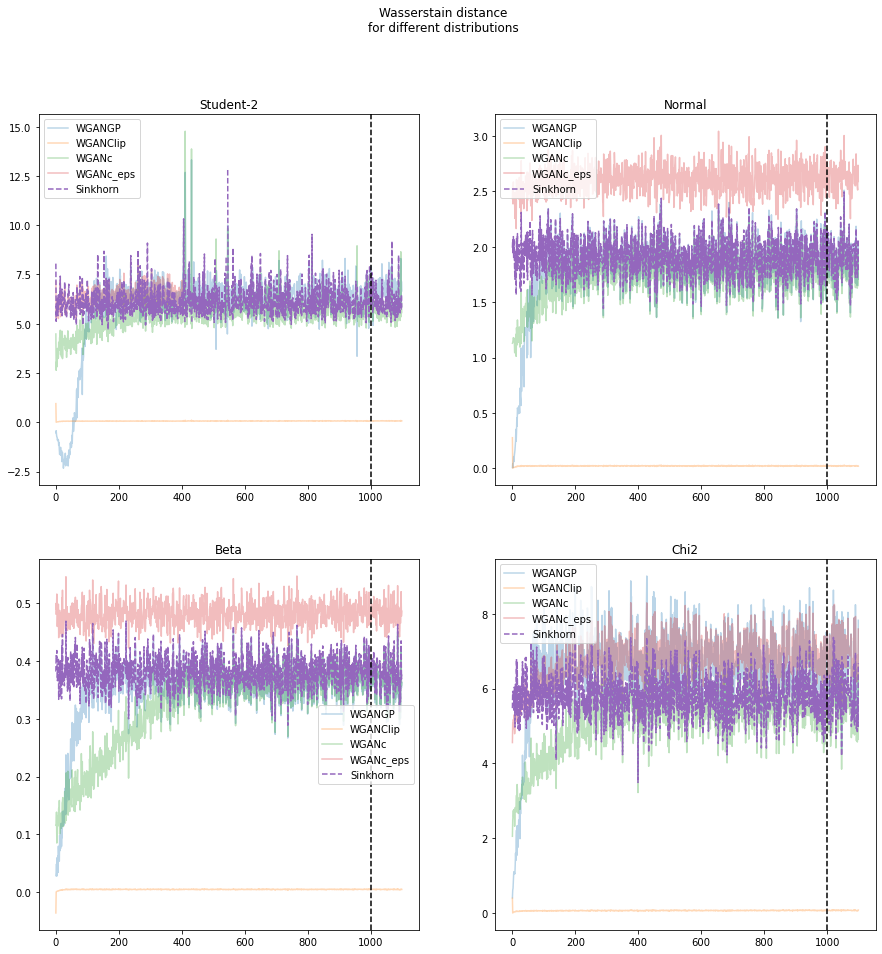

In [38]:
values = list(losses.values())
keys = list(losses.keys())

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("Wasserstain distance\nfor different distributions")
for i, ax in enumerate(axs.flatten()):
    ax.set_title(keys[i])
    for key, item in values[i].items():
        alpha = 1 if key == "Sinkhorn" else 0.3
        linestyle = "--" if key == "Sinkhorn" else None
        ax.plot(item, label=key, alpha=alpha, linestyle=linestyle)
    ax.axvline(cfg["train_epoches"], c="black", linestyle="--")
    ax.legend()
        
plt.show()

### Layer Width influence

In [12]:
mean1 = torch.arange(cfg["batch_size_dist"][1], dtype=torch.float32)
cov1_tril = torch.tril(torch.rand((cfg["batch_size_dist"][1], cfg["batch_size_dist"][1])))
cov1 = cov1_tril@cov1_tril.T

mean2 = torch.arange(cfg["batch_size_dist"][1], cfg["batch_size_dist"][1]*2, dtype=torch.float32)
cov2_tril = torch.tril(torch.rand((cfg["batch_size_dist"][1], cfg["batch_size_dist"][1])))
cov2 = cov2_tril@cov2_tril.T

dist1 = MultivariateNormal(mean1, cov1)
dist2 = MultivariateNormal(mean2, cov2)

In [13]:
layer_width = [16, 32, 64, 128, 256, 512]

#### WGAN Clip

In [14]:
clipper = WeightClipper(cfg["c_Clip"])
netD_Clip_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(cfg["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_Clip_map = dict(zip(layer_width, [RMSprop(
                                   netD_Clip_map[width].parameters(),
                                   lr=cfg["lr_Clip"]
                                ) for width in layer_width]
                            )
                        )

#### WGAN Gradient Penalty

In [15]:
netD_GP_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(cfg["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_GP_map = dict(zip(layer_width, [Adam(
                                    netD_GP_map[width].parameters(),
                                    lr=cfg["lr_GP"],
                                    betas=cfg["betas_GP"]
                                ) for width in layer_width]
                            )
                        )

#### $(c)$-GAN

In [16]:
netD_C_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(cfg["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_C_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_map[width].parameters(),
                                   lr=cfg["lr_c"]
                                ) for width in layer_width]
                            )
                        )

#### $(C, \epsilon)$-GAN

In [17]:
eps=1
netD_C_eps_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(cfg["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_C_eps_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_eps_map[width].parameters(),
                                   lr=cfg["lr_c_eps"]
                                ) for width in layer_width]
                            )
                        )

#### Sinkhorn

In [18]:
sinkhorn = Sinkhorn(eps=cfg["Sinkhorn_eps"])

#### Experiments

In [19]:
cfg["train_epoches"] = 1000

losses = {
    "WGANGP": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANClip": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc_eps": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "Sinkhorn": [],
}

for epoch in (pbar := tqdm(range(cfg["train_epoches"]))):
    X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
    X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

    ### WGANClip
    for width in layer_width:
        optimD_Clip_map[width].zero_grad()
        e_X_1 = netD_Clip_map[width](X_1_batch).mean()
        e_X_2 = netD_Clip_map[width](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip_map[width].step()

        netD_Clip_map[width].apply(clipper)
        losses["WGANClip"][width].append(netD_loss.item())

    ### WGANGP
    for width in layer_width:
        optimD_GP_map[width].zero_grad()
        e_X_1 = netD_GP_map[width](X_1_batch).mean()
        e_X_2 = netD_GP_map[width](X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 

        mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD_GP_map[width](mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - cfg['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP_map[width].step()

        losses["WGANGP"][width].append(netD_loss.item())

    ### WGAN (c)
    for width in layer_width:
        optimD_C_map[width].zero_grad()
        phi_X_1 = netD_C_map[width](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_map[width].step()
        losses["WGANc"][width].append(netD_loss.item())
    
    ### WGAN (c, eps)
    for width in layer_width:
        optimD_C_eps_map[width].zero_grad()
        phi_X_1 = netD_C_eps_map[width](X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps_map[width].step()
        losses["WGANc_eps"][width].append(netD_loss.item())


    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=2)
        a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
for epoch in (pbar := tqdm(range(cfg["val_epoches"]))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
        X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

        ### WGANClip
        for width in layer_width:
            e_X_1 = netD_Clip_map[width](X_1_batch).mean()
            e_X_2 = netD_Clip_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANClip"][width].append(netD_loss.item())

        ### WGANGP
        for width in layer_width:
            e_X_1 = netD_GP_map[width](X_1_batch).mean()
            e_X_2 = netD_GP_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANGP"][width].append(netD_loss.item())

        ### WGAN (c)
        for width in layer_width:
            phi_X_1 = netD_C_map[width](X_1_batch)
            phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)
            netD_loss = phi_X_1.mean() + phi_X_2.mean() 
            losses["WGANc"][width].append(netD_loss.item())

        ### WGAN (c, eps)
        for width in layer_width:
            optimD_C_eps_map[width].zero_grad()
            phi_X_1 = netD_C_eps_map[width](X_1_batch)
            phi_X_2 = -eps*torch.log(
                                    torch.mean(
                                        torch.exp(
                                            -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                        ), 
                                    1, keepdims=True)
                                )
            netD_loss = phi_X_1.mean() + phi_X_2.mean()
            losses["WGANc_eps"][width].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())
            
losses_width = losses

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

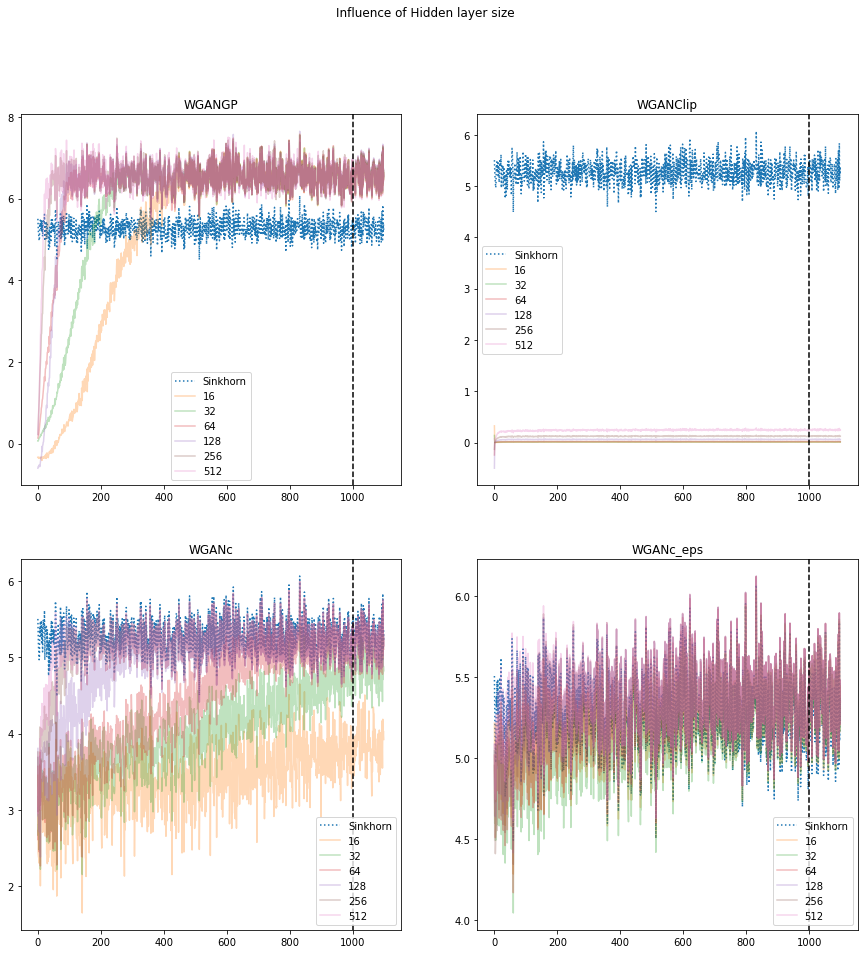

In [22]:
values = list(losses.values())
keys = list(losses.keys())

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("Influence of Hidden layer size")
for i, ax in enumerate(axs.flatten()):
    ax.set_title(keys[i])
    ax.plot(losses["Sinkhorn"], label="Sinkhorn", linestyle = ":")
    for key, item in values[i].items():
        ax.plot(item, label=key, alpha=0.3)
    ax.axvline(cfg["train_epoches"], c="black", linestyle="--")
    ax.legend()
        
plt.show()